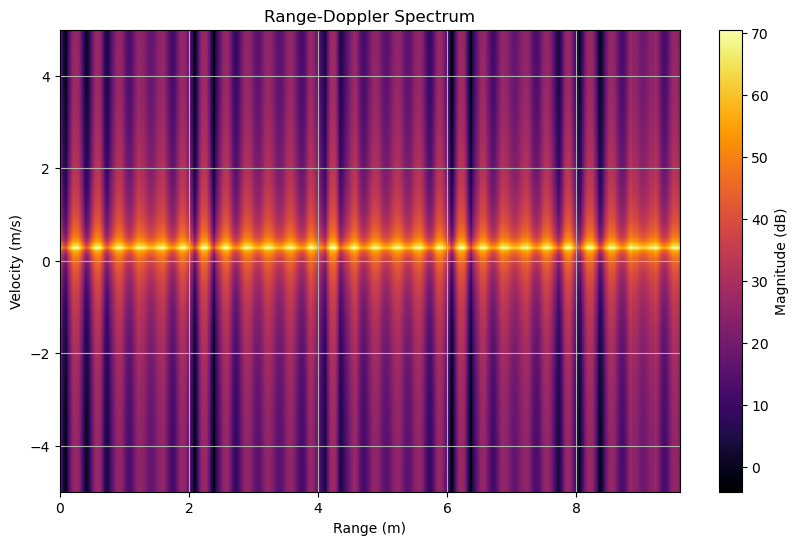

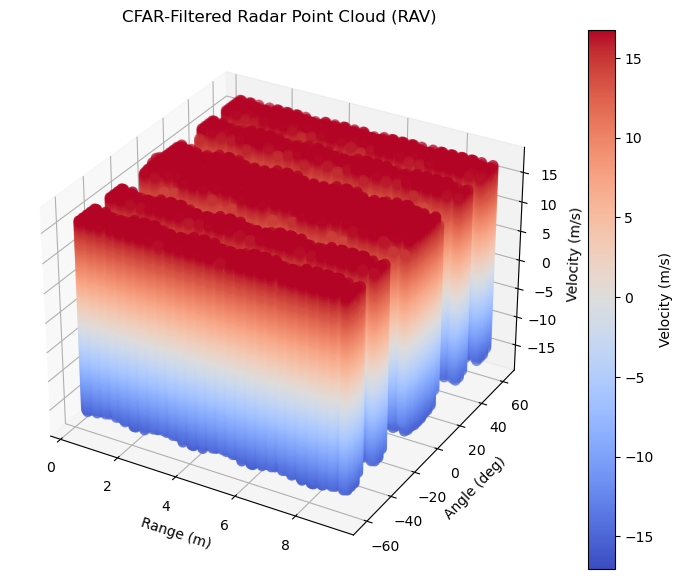

,Range (m),Angle (deg),Velocity (m/s)
0,0.5625,-61.875,-15.523539
1,2.1750,-61.875,-15.523539
2,2.2125,-61.875,-15.523539
3,2.2500,-61.875,-15.523539
4,2.5500,-61.875,-15.523539


In [1]:

# FMCW Radar Simulation - Range, Angle, Velocity with CFAR

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# Radar and signal parameters
c = 3e8
f0 = 77e9
B = 4e9
T_chirp = 50e-6
S = B / T_chirp
num_chirps = 128
num_samples = 256
fs = num_samples / T_chirp
frame_rate = 10
dt = 1 / frame_rate

# Target movement
target_speed = 1.0
target_y = 3.0
x0 = -1.0
frame = 10
t_chirp = np.arange(num_chirps) * T_chirp
t_sample = np.arange(num_samples) / fs
x_pos = x0 + target_speed * frame * dt
r = np.sqrt(x_pos**2 + target_y**2)
angle_rad = np.arctan2(x_pos, target_y)
vr = target_speed * np.cos(angle_rad)
fd = 2 * vr * f0 / c
tau = 2 * r / c

# Simulate signal
data = np.zeros((num_chirps, num_samples), dtype=complex)
for i in range(num_chirps):
    for j in range(num_samples):
        t = t_sample[j]
        beat_freq = S * (t - tau)
        phase = 2 * np.pi * (beat_freq * t + fd * i * T_chirp)
        data[i, j] = np.exp(1j * phase)

# Angle simulation (MIMO)
num_rx = 8
angle_bins = 64
wavelength = c / f0
d = wavelength / 2
data_cube = np.zeros((num_rx, num_chirps, num_samples), dtype=complex)
for ant in range(num_rx):
    phase_shift = 2 * np.pi * d * ant * np.sin(angle_rad) / wavelength
    data_cube[ant, :, :] = data * np.exp(1j * phase_shift)

# 3D FFT
fft_cube = np.fft.fftshift(np.fft.fftn(data_cube, s=(angle_bins, num_chirps, num_samples), axes=(0,1,2)), axes=0)
fft_mag = np.abs(fft_cube)
range_res = c / (2 * B)
velocity_res = c / (2 * f0 * T_chirp * num_chirps)
angle_res = 180 / angle_bins

# Inject background
np.random.seed(42)
num_background_points = 100
background_ranges = np.random.uniform(1, 10, num_background_points)
background_velocities = np.random.uniform(-2, 2, num_background_points)
background_angles = np.random.uniform(-45, 45, num_background_points)
bg_rb = np.clip((background_ranges / range_res).astype(int), 0, num_samples - 1)
bg_vb = np.clip(((background_velocities / velocity_res) + num_chirps // 2).astype(int), 0, num_chirps - 1)
bg_ab = np.clip(((background_angles / angle_res) + angle_bins // 2).astype(int), 0, angle_bins - 1)
for i in range(num_background_points):
    fft_mag[bg_ab[i], bg_vb[i], bg_rb[i]] += np.random.uniform(5, 15)

# CFAR
cfar_threshold = 1.5
cfar_guard = 1
cfar_window = 8
detections = []
shape = fft_mag.shape
for a in range(cfar_window, shape[0] - cfar_window):
    for d in range(cfar_window, shape[1] - cfar_window):
        for r in range(cfar_window, shape[2] - cfar_window):
            local = fft_mag[a - cfar_window:a + cfar_window + 1,
                            d - cfar_window:d + cfar_window + 1,
                            r - cfar_window:r + cfar_window + 1].copy()
            local[cfar_window - cfar_guard:cfar_window + cfar_guard + 1,
                  cfar_window - cfar_guard:cfar_window + cfar_guard + 1,
                  cfar_window - cfar_guard:cfar_window + cfar_guard + 1] = 0
            noise = np.mean(local)
            if fft_mag[a, d, r] > noise * cfar_threshold:
                detections.append((a, d, r))

# Convert to physical values
cfar_points = []
for ab, vb, rb in detections:
    rng = rb * range_res
    vel = (vb - num_chirps // 2) * velocity_res
    ang = (ab - angle_bins // 2) * angle_res
    cfar_points.append((rng, ang, vel))
cfar_df = pd.DataFrame(cfar_points, columns=['Range (m)', 'Angle (deg)', 'Velocity (m/s)'])

# Plot spectrum
plt.figure(figsize=(10, 6))
extent = [0, num_samples * range_res, -frame_rate/2, frame_rate/2]
plt.imshow(20 * np.log10(np.abs(np.fft.fftshift(np.fft.fft2(data), axes=0)) + 1e-6),
           aspect='auto', extent=extent, cmap='inferno', origin='lower')
plt.xlabel('Range (m)')
plt.ylabel('Velocity (m/s)')
plt.title('Range-Doppler Spectrum')
plt.colorbar(label='Magnitude (dB)')
plt.grid(True)
plt.show()

# Plot CFAR 3D Point Cloud
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(cfar_df['Range (m)'], cfar_df['Angle (deg)'], cfar_df['Velocity (m/s)'],
                c=cfar_df['Velocity (m/s)'], cmap='coolwarm', s=50)
ax.set_xlabel('Range (m)')
ax.set_ylabel('Angle (deg)')
ax.set_zlabel('Velocity (m/s)')
ax.set_title('CFAR-Filtered Radar Point Cloud (RAV)')
fig.colorbar(sc, label='Velocity (m/s)')
plt.show()

cfar_df.head()



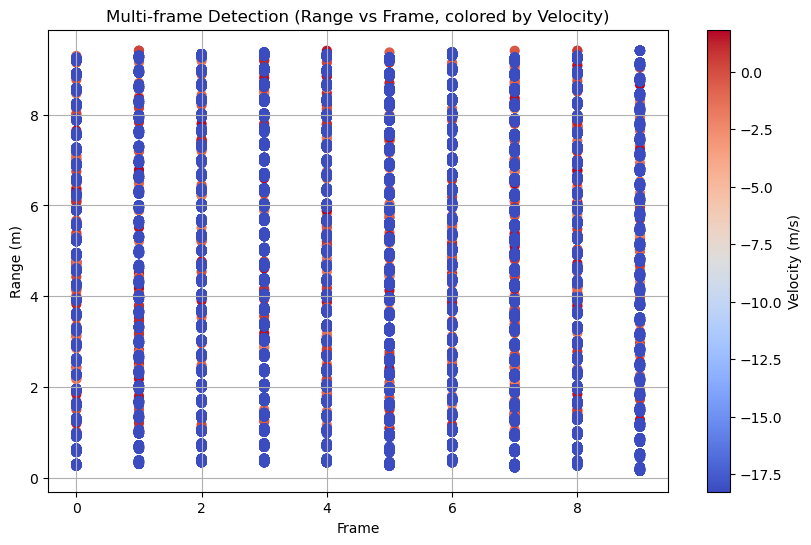

,Frame,Range (m),Angle (deg),Velocity (m/s)
0,0,0.2625,-78.75,-18.262987
1,0,0.6000,-78.75,-18.262987
2,0,0.9375,-78.75,-18.262987
3,0,1.2750,-78.75,-18.262987
4,0,1.6125,-78.75,-18.262987


In [4]:
# -------------------------------
# Multi-frame simulation with FIXES:
# - Windowing added before FFT
# - Background noise randomized per frame
# - CFAR threshold increased to reduce false positives
# -------------------------------
from IPython.display import display, clear_output

frames_to_simulate = 10
all_points = []

# Window functions
range_window = np.hamming(num_samples)
doppler_window = np.hamming(num_chirps)

for frame in range(frames_to_simulate):
    x_pos = x0 + target_speed * frame * dt
    y_pos = target_y * np.random.uniform(0.9, 1.1)
    r = np.sqrt(x_pos**2 + y_pos**2)
    angle_rad = np.arctan2(x_pos, y_pos)
    vr = target_speed * np.cos(angle_rad)
    fd = 2 * vr * f0 / c
    tau = 2 * r / c

    # Regenerate signal
    for i in range(num_chirps):
        for j in range(num_samples):
            t = t_sample[j]
            beat_freq = S * (t - tau)
            phase = 2 * np.pi * (beat_freq * t + fd * i * T_chirp)
            data[i, j] = np.exp(1j * phase)

    # Apply windowing before FFT
    data_win = data * range_window
    data_win = (data_win.T * doppler_window).T

    # Update MIMO data cube
    for ant in range(num_rx):
        phase_shift = 2 * np.pi * d * ant * np.sin(angle_rad) / wavelength
        data_cube[ant, :, :] = data_win * np.exp(1j * phase_shift)

    # FFT
    fft_cube = np.fft.fftshift(np.fft.fftn(data_cube, s=(angle_bins, num_chirps, num_samples), axes=(0,1,2)), axes=0)
    fft_mag = np.abs(fft_cube)

    # Regenerate randomized background noise per frame
    bg_ranges = np.random.uniform(1, 10, num_background_points)
    bg_vels = np.random.uniform(-2, 2, num_background_points)
    bg_angs = np.random.uniform(-45, 45, num_background_points)
    bg_rb = np.clip((bg_ranges / range_res).astype(int), 0, num_samples - 1)
    bg_vb = np.clip(((bg_vels / velocity_res) + num_chirps // 2).astype(int), 0, num_chirps - 1)
    bg_ab = np.clip(((bg_angs / angle_res) + angle_bins // 2).astype(int), 0, angle_bins - 1)
    for i in range(num_background_points):
        fft_mag[bg_ab[i], bg_vb[i], bg_rb[i]] += np.random.uniform(3, 8)

    # CFAR (threshold = 8x noise)
    cfar_threshold = 8.0
    cfar_guard = 1
    cfar_window = 4
    detections = []
    shape = fft_mag.shape
    for a in range(cfar_window, shape[0] - cfar_window):
        for d in range(cfar_window, shape[1] - cfar_window):
            for r in range(cfar_window, shape[2] - cfar_window):
                local = fft_mag[a - cfar_window:a + cfar_window + 1,
                                d - cfar_window:d + cfar_window + 1,
                                r - cfar_window:r + cfar_window + 1].copy()
                local[cfar_window - cfar_guard:cfar_window + cfar_guard + 1,
                      cfar_window - cfar_guard:cfar_window + cfar_guard + 1,
                      cfar_window - cfar_guard:cfar_window + cfar_guard + 1] = 0
                noise = np.mean(local)
                if fft_mag[a, d, r] > noise * cfar_threshold:
                    detections.append((a, d, r))

    for ab, vb, rb in detections:
        rng = rb * range_res
        vel = (vb - num_chirps // 2) * velocity_res
        ang = (ab - angle_bins // 2) * angle_res
        all_points.append((frame, rng, ang, vel))

# Convert to DataFrame
multi_df = pd.DataFrame(all_points, columns=["Frame", "Range (m)", "Angle (deg)", "Velocity (m/s)"])

# Plot multi-frame 2D point cloud
plt.figure(figsize=(10, 6))
plt.scatter(multi_df["Frame"], multi_df["Range (m)"], c=multi_df["Velocity (m/s)"], cmap="coolwarm", s=40)
plt.colorbar(label="Velocity (m/s)")
plt.xlabel("Frame")
plt.ylabel("Range (m)")
plt.title("Multi-frame Detection (Range vs Frame, colored by Velocity)")
plt.grid(True)
plt.show()
multi_df.head()

In [3]:
multi_df.to_csv("Result.csv")